In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression

In [2]:
# Inlezen van de dataset
df = pd.read_excel("C:/Users/20201954/Desktop/data/merged_data_MRI_isolation_forest.xlsx")
df = df.drop(columns=['dix_snr', 'dti_snr0','Unnamed: 0', 'dti_l1', 'dti_l2', 'dti_l3'])

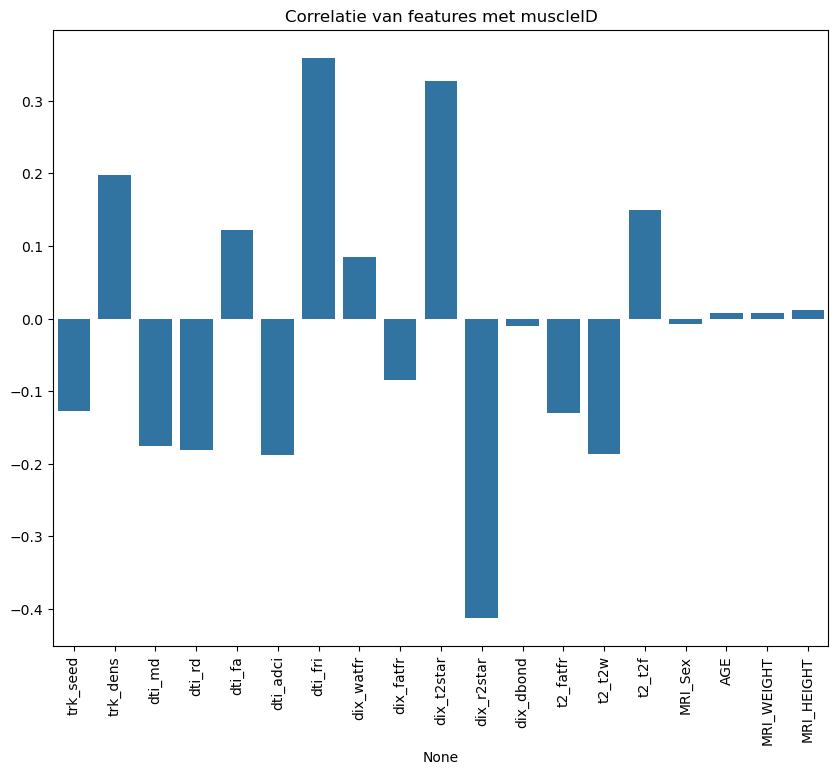

In [3]:
# Correlatie berekenen
corr_matrix = df.corr()

# Correlatie met muscleID
correlation_with_target = corr_matrix['muscleID'].drop('muscleID')

# Plotten
plt.figure(figsize=(10,8))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
plt.xticks(rotation=90)
plt.title("Correlatie van features met muscleID")
plt.show()

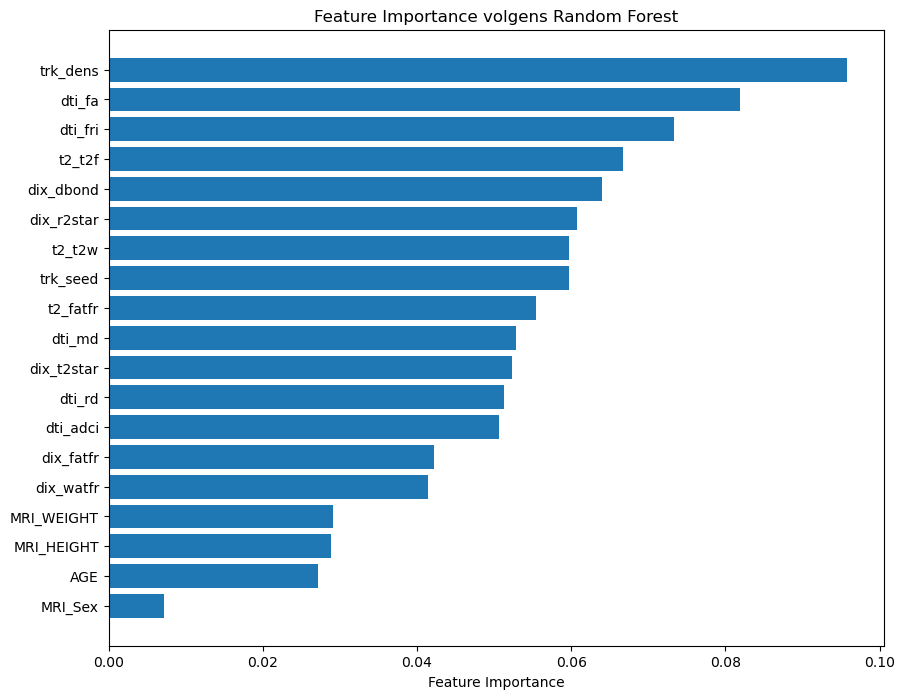

In [4]:
# Data splitsen
X = df.drop(columns=['muscleID'])  # features
y = df['muscleID']  # target

# Random Forest model trainen
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature Importance
importances = rf.feature_importances_

# Feature importance plotten
indices = np.argsort(importances)
plt.figure(figsize=(10,8))
plt.barh(range(X.shape[1]), importances[indices], align='center')
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importance volgens Random Forest")
plt.show()


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Recursive Feature Elimination (RFE) with Logistic Regression ###

# Define the Logistic Regression model with increased max_iter
model = LogisticRegression(max_iter=2000, solver='lbfgs')  # Increased max_iter to avoid convergence issue

# Apply RFE for feature selection
rfe = RFE(model, n_features_to_select=5)  # Adjust the number of features you want to select
rfe.fit(X_train_scaled, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_].tolist()
print("Selected Features using RFE:", selected_features)

Selected Features using RFE: ['trk_dens', 'dti_fa', 'dti_fri', 'dix_t2star', 'dix_r2star']


In [6]:
# Random Forest model aanmaken
model = RandomForestClassifier(n_estimators=100, random_state=42)

# RFE uitvoeren
rfe = RFE(estimator=model, n_features_to_select=10)  # Selecteer 10 beste features
rfe.fit(X, y)

# Belangrijkste features
selected_features = X.columns[rfe.support_]
print("Belangrijkste features volgens RFE:", selected_features)

Belangrijkste features volgens RFE: Index(['trk_seed', 'trk_dens', 'dti_md', 'dti_fa', 'dti_fri', 'dix_r2star',
       'dix_dbond', 't2_fatfr', 't2_t2w', 't2_t2f'],
      dtype='object')


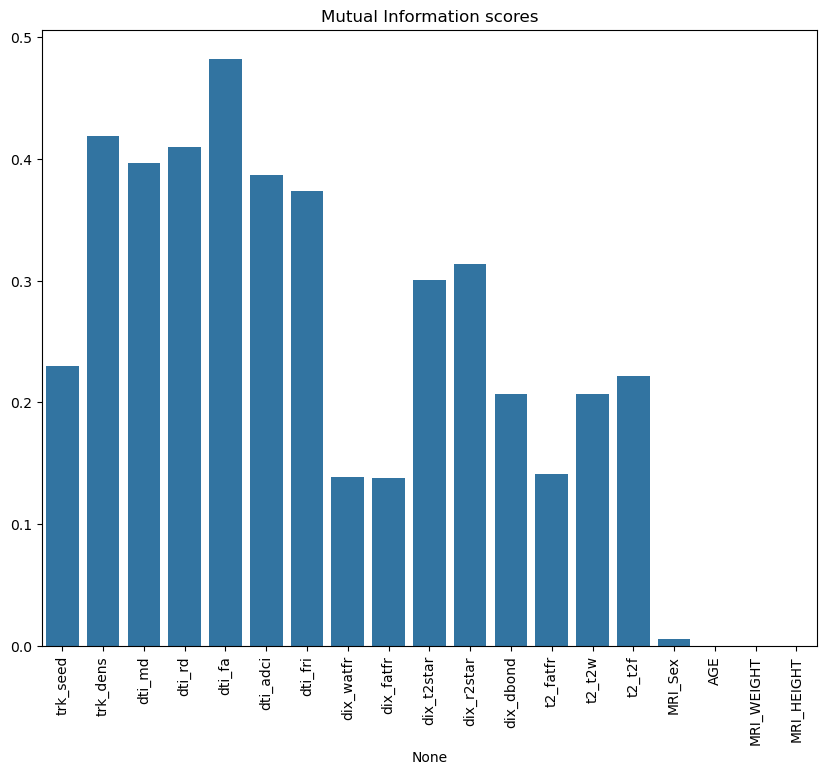

In [7]:
# Mutual information berekenen
mutual_info = mutual_info_classif(X, y)

# Plotten
plt.figure(figsize=(10,8))
sns.barplot(x=X.columns, y=mutual_info)
plt.xticks(rotation=90)
plt.title("Mutual Information scores")
plt.show()


Belangrijkste features volgens Lasso: Index(['trk_seed', 'trk_dens', 'dti_fri', 'dix_watfr', 'dix_r2star',
       'dix_dbond', 't2_fatfr', 't2_t2w', 't2_t2f', 'MRI_Sex', 'AGE'],
      dtype='object')


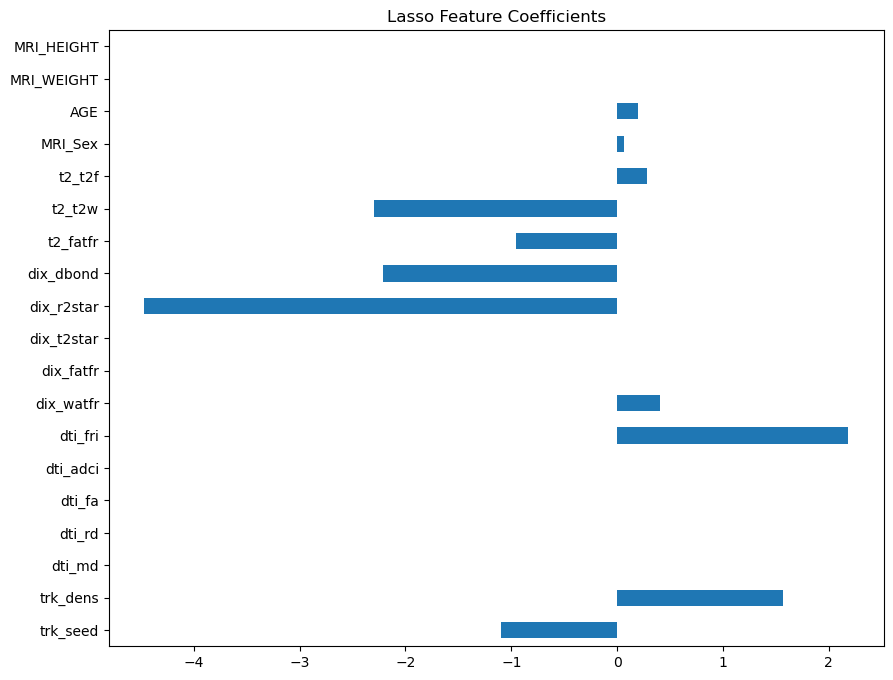

In [8]:
# Data schalen
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso model trainen
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Feature coëfficiënten
lasso_coeff = pd.Series(lasso.coef_, index=X.columns)

# Niet-nul coëfficiënten zijn de geselecteerde features
selected_features = lasso_coeff[lasso_coeff != 0].index
print("Belangrijkste features volgens Lasso:", selected_features)

# Plotten van de coëfficiënten
plt.figure(figsize=(10,8))
lasso_coeff.plot(kind='barh')
plt.title("Lasso Feature Coefficients")
plt.show()

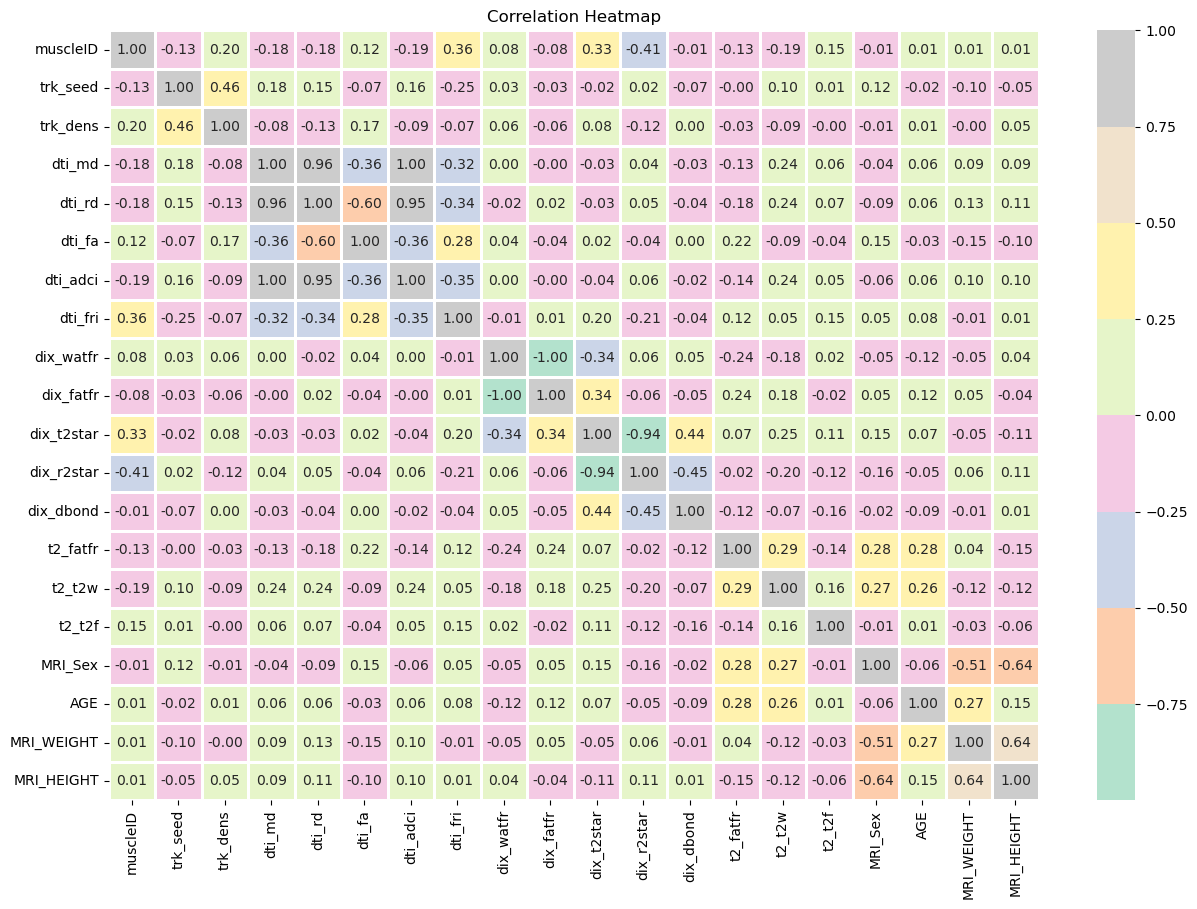

In [9]:
plt.figure(figsize=(15, 10))

sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

In [10]:
# Identifying high correlations above 0.95
correlation_matrix = df.corr()
high_correlations = correlation_matrix[correlation_matrix > 0.85]

# Filtering out correlations equal to 1.0 (self-correlations)
filtered_high_correlations = high_correlations[high_correlations != 1.0].stack()

# Printing the filtered high correlations
print(filtered_high_correlations)

dti_md    dti_rd      0.957496
          dti_adci    0.996046
dti_rd    dti_md      0.957496
          dti_adci    0.954154
dti_adci  dti_md      0.996046
          dti_rd      0.954154
dtype: float64


In [11]:
specific_feature = 'muscleID'

specific_feature_correlations = correlation_matrix[specific_feature]

# Filteren van zelf-correlaties 
filtered_feature_correlations = specific_feature_correlations[specific_feature_correlations != 1.0]

print(filtered_feature_correlations)


trk_seed     -0.126858
trk_dens      0.197855
dti_md       -0.175128
dti_rd       -0.180647
dti_fa        0.122022
dti_adci     -0.187492
dti_fri       0.359345
dix_watfr     0.084845
dix_fatfr    -0.084843
dix_t2star    0.326897
dix_r2star   -0.412315
dix_dbond    -0.009862
t2_fatfr     -0.130605
t2_t2w       -0.186208
t2_t2f        0.148980
MRI_Sex      -0.007085
AGE           0.007063
MRI_WEIGHT    0.007407
MRI_HEIGHT    0.012207
Name: muscleID, dtype: float64
